In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.integrate as integrate
import matplotlib.pyplot as plt


2024-05-08 01:46:40.864512: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 01:46:40.864550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 01:46:40.866030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 01:46:40.873109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 01:46:41.613589: W tensorflow/compiler/tf2

In [2]:
# Load the base VGG16 model, pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze all layers except last four layers 
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


2024-05-08 01:46:42.747691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 01:46:42.791454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 01:46:42.791931: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)



In [4]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])



In [5]:
# # Create data generators for training and validation
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

# train_generator = train_datagen.flow_from_directory(
#         'cleaned_images',
#         target_size=(299, 299),
#         batch_size=32,
#         class_mode='binary')


In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="../cleaned_images/images",
    labels="inferred",
    label_mode="int",
    class_names=["unhealthy", "healthy"],
    batch_size=16, # Prev 32
    image_size=(299, 299),
    shuffle=True,
    # color_mode='grayscale',
    seed=42,
)

DATASET_SIZE = 200

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

Found 3194 files belonging to 2 classes.


In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train the model
# history = model.fit(
#       train_generator,
#       steps_per_epoch=train_generator.samples//train_generator.batch_size,  callbacks=[callback],
#       epochs=100)

history = model.fit(train_dataset, validation_data = val_dataset, epochs=100, callbacks=[callback])


Epoch 1/100


2024-05-08 01:47:02.684528: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-08 01:47:09.439921: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d10b8454cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 01:47:09.439965: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-05-08 01:47:09.445495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715113029.529234   63495 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 [==============================] - 33s 163ms/step - loss: 5.4462 - accuracy: 0.6161 - val_loss: 1.9444 - val_accuracy: 0.7300
Epoch 2/100
140/140 [==============================] - 18s 126ms/step - loss: 4.7044 - accuracy: 0.6205 - val_loss: 2.5496 - val_accuracy: 0.7257
Epoch 3/100
140/140 [==============================] - 18s 127ms/step - loss: 3.9886 - accuracy: 0.6411 - val_loss: 1.7685 - val_accuracy: 0.7384
Epoch 4/100
140/140 [==============================] - 18s 127ms/step - loss: 3.8028 - accuracy: 0.6366 - val_loss: 1.2060 - val_accuracy: 0.7363
Epoch 5/100
140/140 [==============================] - 18s 127ms/step - loss: 3.4146 - accuracy: 0.6500 - val_loss: 1.2010 - val_accuracy: 0.7616
Epoch 6/100
140/140 [==============================] - 18s 126ms/step - loss: 3.0274 - accuracy: 0.6540 - val_loss: 1.0098 - val_accuracy: 0.7363
Epoch 7/100
140/140 [==============================] - 18s 130ms/step - loss: 2.5715 - accuracy: 0.6741 - val_loss: 0.9763 - val_accurac

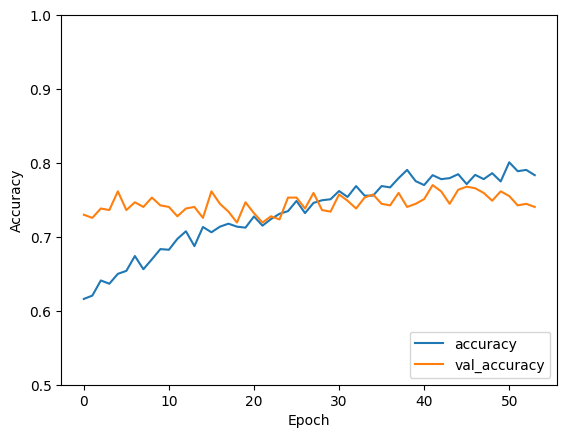

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

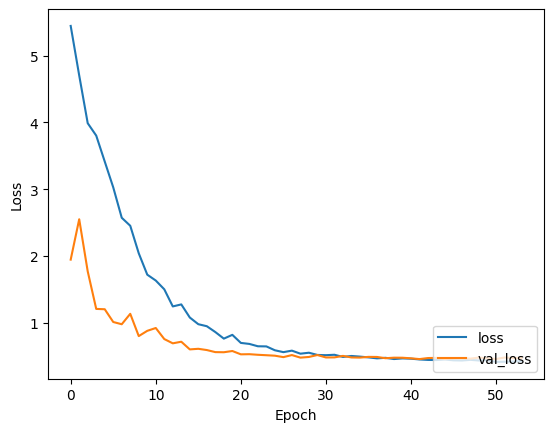

In [9]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [10]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=train_generator.samples//train_generator.batch_size,  callbacks=[callback],
#       epochs=100)

history = model.fit(train_dataset, validation_data = val_dataset, epochs=100, callbacks=[callback])


Epoch 1/100
140/140 [==============================] - 31s 164ms/step - loss: 0.5607 - accuracy: 0.7134 - val_loss: 0.4889 - val_accuracy: 0.7511
Epoch 2/100
140/140 [==============================] - 22s 158ms/step - loss: 0.4831 - accuracy: 0.7607 - val_loss: 0.4580 - val_accuracy: 0.7553
Epoch 3/100
140/140 [==============================] - 22s 158ms/step - loss: 0.4500 - accuracy: 0.7723 - val_loss: 0.4483 - val_accuracy: 0.7785
Epoch 4/100
140/140 [==============================] - 22s 158ms/step - loss: 0.4381 - accuracy: 0.7804 - val_loss: 0.4488 - val_accuracy: 0.7722
Epoch 5/100
140/140 [==============================] - 22s 158ms/step - loss: 0.4069 - accuracy: 0.7964 - val_loss: 0.4322 - val_accuracy: 0.7764
Epoch 6/100
140/140 [==============================] - 22s 158ms/step - loss: 0.3940 - accuracy: 0.7987 - val_loss: 0.4527 - val_accuracy: 0.7743
Epoch 7/100
140/140 [==============================] - 22s 160ms/step - loss: 0.3684 - accuracy: 0.8085 - val_loss: 0.4534 -

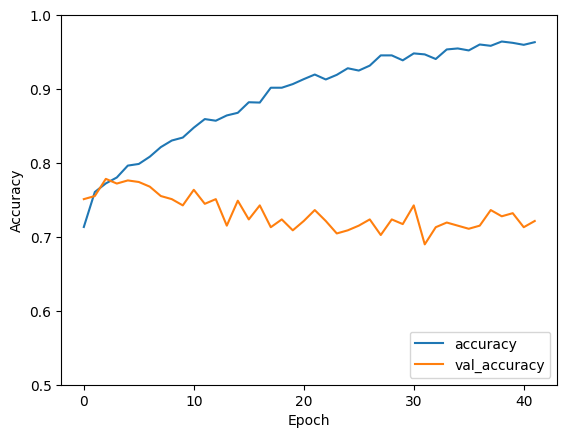

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

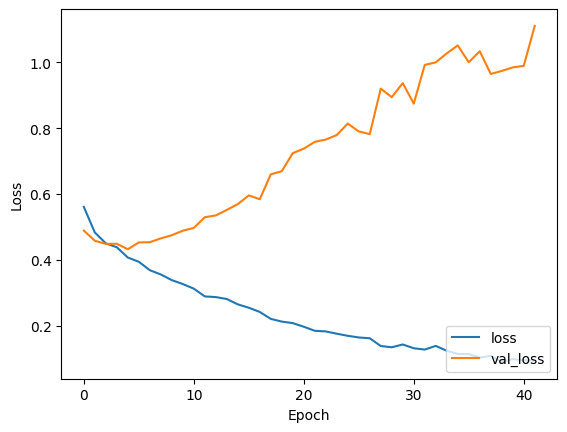

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [15]:
loss, accuracy= model.evaluate(test_dataset, verbose=2)

print(f'loss = {loss}')
print(f'accuracy = {accuracy}')

30/30 - 3s - loss: 0.8451 - accuracy: 0.7896 - 3s/epoch - 115ms/step
loss = 0.845138430595398
accuracy = 0.7895833253860474


In [21]:
from tensorflow.keras.metrics import Precision, Recall

In [22]:
precision = Precision()
recall = Recall()

In [23]:
for batch in test_dataset.as_numpy_iterator():
    x,y=batch
    yPred=model.predict(x)
    precision.update_state(y,yPred)
    recall.update_state(y, yPred)

print(f"Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}")

1/1 [==============================] - 0s 25ms/step
Precision:0.7142857313156128, Recall:0.5414012670516968


In [16]:
model.save("InceptionV3final.Keras")

INFO:tensorflow:Assets written to: InceptionV3final.Keras/assets


INFO:tensorflow:Assets written to: InceptionV3final.Keras/assets


In [17]:
import numpy as np
from tensorflow import keras

In [18]:
# Define the last convolutional layer name
last_conv_layer_name = "mixed10"

# Define the image size
img_size = (299, 299)

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 3s 3s/step


2024-05-08 02:40:26.421801: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-08 02:40:26.493253: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


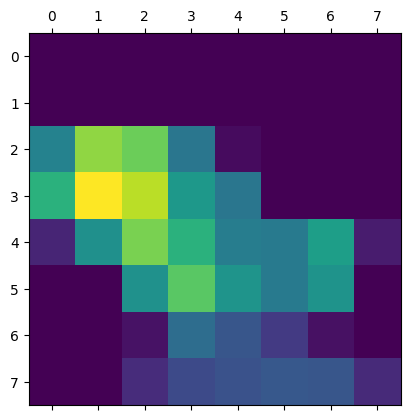

In [19]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img_path = "../PCOSGen-train/images/unhealthy/15image0033.jpg"

model_builder = keras.applications.InceptionV3
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
model.layers[-1].activation =None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name) # or mixed10

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [20]:
from PIL import Image
def save_and_display_gradcam(img_path, heatmap, cam_path="attn.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

save_and_display_gradcam(img_path, heatmap)

/tmp/ipykernel_63429/3365334788.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")
